# Train model

Much of the code is modified from `Fregly, C., & Barth, A. (2021). Data science on AWS: Implementing end-to-end, continuous AI and machine learning pipelines. O’Reilly.`

## Install missing dependencies

[PyAthena](https://pypi.org/project/PyAthena/) is a Python DB API 2.0 (PEP 249) compliant client for Amazon Athena.

In [37]:
!pip install --disable-pip-version-check -q PyAthena==2.1.0
!pip install --disable-pip-version-check -q sagemaker-experiments==0.1.26
!pip install missingno
!pip install xgboost
!pip install torch==1.8.1
#!pip install torchvision

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 804.1/804.1 MB 1.0 MB/s eta 0:00:0000:0100:01


## Globally import libraries

In [36]:
import boto3
from botocore.client import ClientError
import pandas as pd
import numpy as np
from pyathena import connect
from IPython.core.display import display, HTML
import missingno as msno
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import make_pipeline, Pipeline
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.ensemble import RandomForestRegressor
from sagemaker.tuner import HyperparameterTuner
from sklearn.linear_model import LinearRegression
from sklearn.neural_network import MLPRegressor
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.impute import SimpleImputer
from sklearn.metrics import r2_score, mean_squared_error
from sklearn.linear_model import Lasso
import datetime as dt
import time
import sagemaker
from smexperiments.experiment import Experiment
from smexperiments.trial import Trial
import joblib
import os

ModuleNotFoundError: No module named 'torch'

## Instantiate AWS SageMaker and S3 sessions

In [4]:
session = boto3.session.Session()
sess = sagemaker.Session()
role = sagemaker.get_execution_role()
region = session.region_name
sagemaker_session = sagemaker.Session()
def_bucket = sagemaker_session.default_bucket()
bucket = 't8-test-final'

s3 = boto3.Session().client(service_name="s3",
                            region_name=region)

sm = boto3.Session().client(service_name="sagemaker",
                            region_name=region)

In [5]:
setup_s3_bucket_passed = False
ingest_create_athena_db_passed = False
ingest_create_athena_table_tsv_passed = False

In [6]:
print(f"Default bucket: {def_bucket}")
print(f"Public T8 bucket: {bucket}")

Default bucket: sagemaker-us-east-1-122149314005
Public T8 bucket: t8-test-final


## Verify S3 Bucket Creation

In [7]:
%%bash

aws s3 ls s3://${bucket}/

2023-03-18 20:53:08 aws-athena-query-results-122149314005-us-east-1
2023-03-05 21:53:59 sagemaker-studio-122149314005-sw16ud198bb
2023-03-05 21:59:02 sagemaker-us-east-1-122149314005
2023-03-19 21:18:45 t8-mc-access
2023-03-23 20:28:25 t8-test-final


In [8]:
response = None

try:
    response = s3.head_bucket(Bucket=bucket)
    print(response)
    setup_s3_bucket_passed = True
except ClientError as e:
    print(f"[ERROR] Cannot find bucket {bucket} in {response} due to {e}.")

{'ResponseMetadata': {'RequestId': 'ZERW41J0A920GJKT', 'HostId': 'vhG9zTYVva1TPUdeUaFpzfCwVnWsg5Bxs98GWURjnvuv9KcU46GC78IYlE+i1EcaoHaFT1NO0Xs=', 'HTTPStatusCode': 200, 'HTTPHeaders': {'x-amz-id-2': 'vhG9zTYVva1TPUdeUaFpzfCwVnWsg5Bxs98GWURjnvuv9KcU46GC78IYlE+i1EcaoHaFT1NO0Xs=', 'x-amz-request-id': 'ZERW41J0A920GJKT', 'date': 'Tue, 04 Apr 2023 04:05:28 GMT', 'x-amz-bucket-region': 'us-east-1', 'x-amz-access-point-alias': 'false', 'content-type': 'application/xml', 'server': 'AmazonS3'}, 'RetryAttempts': 0}}


In [9]:
%store setup_s3_bucket_passed

Stored 'setup_s3_bucket_passed' (bool)


## Pass in ABT from CSV

In [10]:
s3_abt_csv_path = f"s3://{def_bucket}/team_8_data/abt/abt_encoded_df01.csv"
abt_encoded_df01 = pd.read_csv(s3_abt_csv_path)

In [11]:
y01 = ['childpoverty']
abt_encoded_y01_vc01 = abt_encoded_df01[y01].to_numpy()
print(abt_encoded_y01_vc01.shape)
display(abt_encoded_y01_vc01[0:11])
abt_encoded_x01_df01 = abt_encoded_df01.drop(y01, axis=1)
print(abt_encoded_x01_df01.shape)
display(abt_encoded_x01_df01.head(11))

(31605, 1)


array([[20.7],
       [23.6],
       [35.9],
       [31.5],
       [67.7],
       [68.3],
       [ 0. ],
       [62.4],
       [64.9],
       [63.1],
       [ 6.5]])

(31605, 49)


,borough_bronx,borough_brooklyn,borough_manhattan,borough_queens,borough_staten island,relative_data_year_-4,relative_data_year_-3,relative_data_year_-2,relative_data_year_-1,relative_data_year_0,...,walk,othertransp,workathome,meancommute,employed,privatework,publicwork,selfemployed,familywork,unemployment
0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,...,2.9,0.0,0.0,43.0,2308.0,80.8,16.2,2.9,0.0,7.7
1,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,...,1.4,0.5,2.1,45.0,2675.0,71.7,25.3,2.5,0.6,9.5
2,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,...,8.6,1.6,1.7,38.8,2120.0,75.0,21.3,3.8,0.0,8.7
3,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,...,3.0,2.4,6.2,45.4,1083.0,76.8,15.5,7.7,0.0,19.2
4,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,...,4.3,1.0,0.0,46.0,2508.0,71.0,21.3,7.7,0.0,17.2
5,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,...,14.0,1.5,4.1,42.7,1191.0,74.2,16.1,9.7,0.0,18.9
6,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,NaN,113.0,62.8,37.2,0.0,0.0,0.0
7,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,...,17.7,1.8,2.7,35.5,1691.0,85.1,8.3,6.1,0.5,9.4
8,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,...,18.0,0.0,1.6,42.8,1102.0,86.9,8.5,4.5,0.0,15.2
9,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,...,7.1,0.7,0.5,44.0,1559.0,75.0,14.0,11.0,0.0,10.6


In [12]:
abt_encoded_x01_df02 = abt_encoded_x01_df01.fillna(abt_encoded_x01_df01.median())

data_types = abt_encoded_x01_df02.dtypes
data_types = pd.DataFrame(data_types)
data_types = data_types.assign(Null_Values = 
                               abt_encoded_x01_df02.isnull().sum())
data_types.reset_index(inplace = True)
data_types.rename(columns={0:'Data Type',
                          'index': 'Column/Variable',
                          'Null_Values': "# of Nulls"})

,Column/Variable,Data Type,# of Nulls
0,borough_bronx,float64,0
1,borough_brooklyn,float64,0
2,borough_manhattan,float64,0
3,borough_queens,float64,0
4,borough_staten island,float64,0
5,relative_data_year_-4,float64,0
6,relative_data_year_-3,float64,0
7,relative_data_year_-2,float64,0
8,relative_data_year_-1,float64,0
9,relative_data_year_0,float64,0


In [13]:
abt_encoded_x01_df02['boroughs'] = abt_encoded_x01_df02['borough_bronx'].astype(int).astype(str) + abt_encoded_x01_df02['borough_brooklyn'].astype(int).astype(str) + abt_encoded_x01_df02['borough_manhattan'].astype(int).astype(str) + abt_encoded_x01_df02['borough_queens'].astype(int).astype(str) + abt_encoded_x01_df02['borough_staten island'].astype(int).astype(str)
display(abt_encoded_x01_df02.head(5))

scaler = StandardScaler()
abt_encoded_x01_df02_scaled = scaler.fit_transform(abt_encoded_x01_df02.drop(['boroughs', 'poverty'], axis=1))

train_x01, test_x01, train_y01, test_y01 = train_test_split(abt_encoded_x01_df02_scaled,
                                                            abt_encoded_y01_vc01,
                                                            test_size=.2,
                                                            stratify=abt_encoded_x01_df02[['boroughs']],
                                                            shuffle=True,
                                                            random_state=1699)

train_x01 = pd.DataFrame(train_x01, columns=abt_encoded_x01_df02.drop(['boroughs', 'poverty'], axis=1).columns)
test_x01 = pd.DataFrame(test_x01, columns=abt_encoded_x01_df02.drop(['boroughs', 'poverty'], axis=1).columns)

train_y01 = train_y01.ravel()
test_y01 = test_y01.ravel()


print(f'{train_x01.shape}')
print(f'{train_y01.shape}')
print(f'\n{test_x01.shape}')
print(f'{test_y01.shape}')

,borough_bronx,borough_brooklyn,borough_manhattan,borough_queens,borough_staten island,relative_data_year_-4,relative_data_year_-3,relative_data_year_-2,relative_data_year_-1,relative_data_year_0,...,othertransp,workathome,meancommute,employed,privatework,publicwork,selfemployed,familywork,unemployment,boroughs
0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,43.0,2308.0,80.8,16.2,2.9,0.0,7.7,10000
1,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,...,0.5,2.1,45.0,2675.0,71.7,25.3,2.5,0.6,9.5,10000
2,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,...,1.6,1.7,38.8,2120.0,75.0,21.3,3.8,0.0,8.7,10000
3,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,...,2.4,6.2,45.4,1083.0,76.8,15.5,7.7,0.0,19.2,10000
4,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,...,1.0,0.0,46.0,2508.0,71.0,21.3,7.7,0.0,17.2,10000


(25284, 48)
(25284,)

(6321, 48)
(6321,)


#### Untuned Linear Regression Model

In [14]:
# create an un-tuned linear regression model
lin_reg = LinearRegression()

# fit the model to the training set
lin_reg.fit(train_x01, train_y01)

# make predictions on the validation set
lin_reg_pred = lin_reg.predict(test_x01)


In [15]:
# calculate the model performance metrics
lin_reg_mse = mean_squared_error(test_y01, lin_reg_pred)
lin_reg_rmse = lin_reg_mse ** 0.5
lin_reg_r2 = r2_score(test_y01, lin_reg_pred)

# print the performance metrics
print(f"Un-tuned Linear Regression Model: RMSE = {lin_reg_rmse:.3f}, R-squared = {lin_reg_r2:.3f}")

Un-tuned Linear Regression Model: RMSE = 11.331, R-squared = 0.648


#### Random Forest

In [40]:
# Define the hyperparameters to tune
param_dist = {
    'n_estimators': randint(50, 200),
    'max_depth': randint(3, 10),
    'min_samples_split': uniform(0.01, 0.19),
    'min_samples_leaf': uniform(0.01, 0.19),
    'max_features': ['auto', 'sqrt']
}

# Create the Random Forest Regressor model
rf = RandomForestRegressor(random_state=42)

# Perform a randomized search to find the best hyperparameters
random_search = RandomizedSearchCV(estimator=rf, param_distributions=param_dist, cv=5, n_iter=10, n_jobs=-1)
random_search.fit(train_x01, train_y01)

# Print the best hyperparameters found
print("Best hyperparameters: ", random_search.best_params_)


Best hyperparameters:  {'max_depth': 5, 'max_features': 'auto', 'min_samples_leaf': 0.05482542923388117, 'min_samples_split': 0.12414899564785374, 'n_estimators': 153}


In [41]:
# Make predictions on the train and test data
rf_train_preds = random_search.predict(train_x01)
rf_test_preds = random_search.predict(test_x01)

In [45]:
# Evaluate the performance of the model using mean squared error
train_rf_mse = mean_squared_error(train_y01, rf_train_preds)
train_rf_rmse = train_rf_mse ** 0.5
train_rf_r2 = r2_score(train_y01, rf_train_preds)
print(f"XGBoost train model performance: RMSE = {train_rf_rmse:.3f}, R-squared = {train_rf_r2:.3f}")

# Evaluate the performance of the model using mean squared error
test_rf_mse = mean_squared_error(test_y01, rf_test_preds)
test_rf_rmse = test_rf_mse ** 0.5
test_rf_r2 = r2_score(test_y01, rf_test_preds)
print(f"XGBoost test model performance: RMSE = {test_rf_rmse:.3f}, R-squared = {test_rf_r2:.3f}")

XGBoost train model performance: RMSE = 11.276, R-squared = 0.644
XGBoost test model performance: RMSE = 11.301, R-squared = 0.650


#### XGBoost

In [16]:
# Set the hyperparameters for the Gradient Boosting Regressor model
params = {
    'max_depth': 5,
    'learning_rate': 0.1,
    'loss': 'ls'
}

# Train the Gradient Boosting Regressor model
model = GradientBoostingRegressor(**params)
model.fit(train_x01, train_y01)

# Make predictions on the train data
xgb_y__train_pred = model.predict(train_x01)

# Make predictions on the test data
xgb_y_pred = model.predict(test_x01)

In [18]:
# Evaluate the performance of the model using mean squared error
train_xgb_mse = mean_squared_error(train_y01, xgb_y__train_pred)
train_xgb_rmse = train_xgb_mse ** 0.5
train_xgb_r2 = r2_score(train_y01, xgb_y__train_pred)
print(f"XGBoost train model performance: RMSE = {train_xgb_rmse:.3f}, R-squared = {train_xgb_r2:.3f}")

# Evaluate the performance of the model using mean squared error
test_xgb_mse = mean_squared_error(test_y01, xgb_y_pred)
test_xgb_rmse = test_xgb_mse ** 0.5
test_xgb_r2 = r2_score(test_y01, xgb_y_pred)
print(f"XGBoost test model performance: RMSE = {test_xgb_rmse:.3f}, R-squared = {test_xgb_r2:.3f}")

XGBoost train model performance: RMSE = 5.204, R-squared = 0.924
XGBoost test model performance: RMSE = 5.327, R-squared = 0.922


##### Tuned XGBoost

In [19]:
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import randint, uniform

# Define the hyperparameters to tune
param_dist = {
    'max_depth': randint(3, 10),
    'learning_rate': uniform(0.05, 0.5),
    'loss': ['ls', 'lad', 'huber']
}

# Create the Gradient Boosting Regressor model
gbm = GradientBoostingRegressor()

# Perform a randomized search to find the best hyperparameters
random_search = RandomizedSearchCV(estimator=gbm, param_distributions=param_dist, cv=3, n_iter=10, n_jobs=-1)
random_search.fit(train_x01, train_y01)

# Print the best hyperparameters found
print("Best hyperparameters: ", random_search.best_params_)

Best hyperparameters:  {'learning_rate': 0.4911814805544623, 'loss': 'ls', 'max_depth': 8}


In [20]:
# Train the model with the best hyperparameters found
xgb_tune_model = GradientBoostingRegressor(**random_search.best_params_)
xgb_tune_model.fit(train_x01, train_y01)

GradientBoostingRegressor(alpha=0.9, ccp_alpha=0.0, criterion='friedman_mse',
                          init=None, learning_rate=0.4911814805544623,
                          loss='ls', max_depth=8, max_features=None,
                          max_leaf_nodes=None, min_impurity_decrease=0.0,
                          min_impurity_split=None, min_samples_leaf=1,
                          min_samples_split=2, min_weight_fraction_leaf=0.0,
                          n_estimators=100, n_iter_no_change=None,
                          presort='deprecated', random_state=None,
                          subsample=1.0, tol=0.0001, validation_fraction=0.1,
                          verbose=0, warm_start=False)

In [21]:
# Make predictions on the train data
xgb_tune_ytrain_pred = xgb_tune_model.predict(train_x01)

# Evaluate the performance of the model using mean squared error
xgb_tune_ytrain_mse = mean_squared_error(train_y01, xgb_tune_ytrain_pred)
xgb_tune_ytrain_rmse = xgb_tune_ytrain_mse ** 0.5
xgb_tune_ytrain_r2 = r2_score(train_y01, xgb_tune_ytrain_pred)
print(f"XGBoost model train performance: RMSE = {xgb_tune_ytrain_rmse:.3f}, R-squared = {xgb_tune_ytrain_r2:.3f}")

# Make predictions on the test data
xgb_tune_ytest_pred = xgb_tune_model.predict(test_x01)

# Evaluate the performance of the model using mean squared error
xgb_tune_ytest_mse = mean_squared_error(test_y01, xgb_tune_ytest_pred)
xgb_tune_ytest_rmse = xgb_tune_ytest_mse ** 0.5
xgb_tune_ytest_r2 = r2_score(test_y01, xgb_tune_ytest_pred)
print(f"XGBoost model test performance: RMSE = {xgb_tune_ytest_rmse:.3f}, R-squared = {xgb_tune_ytest_r2:.3f}")

XGBoost model train performance: RMSE = 0.002, R-squared = 1.000
XGBoost model test performance: RMSE = 0.002, R-squared = 1.000


In [22]:
# r2 of 1 is a bit... suspicious. 

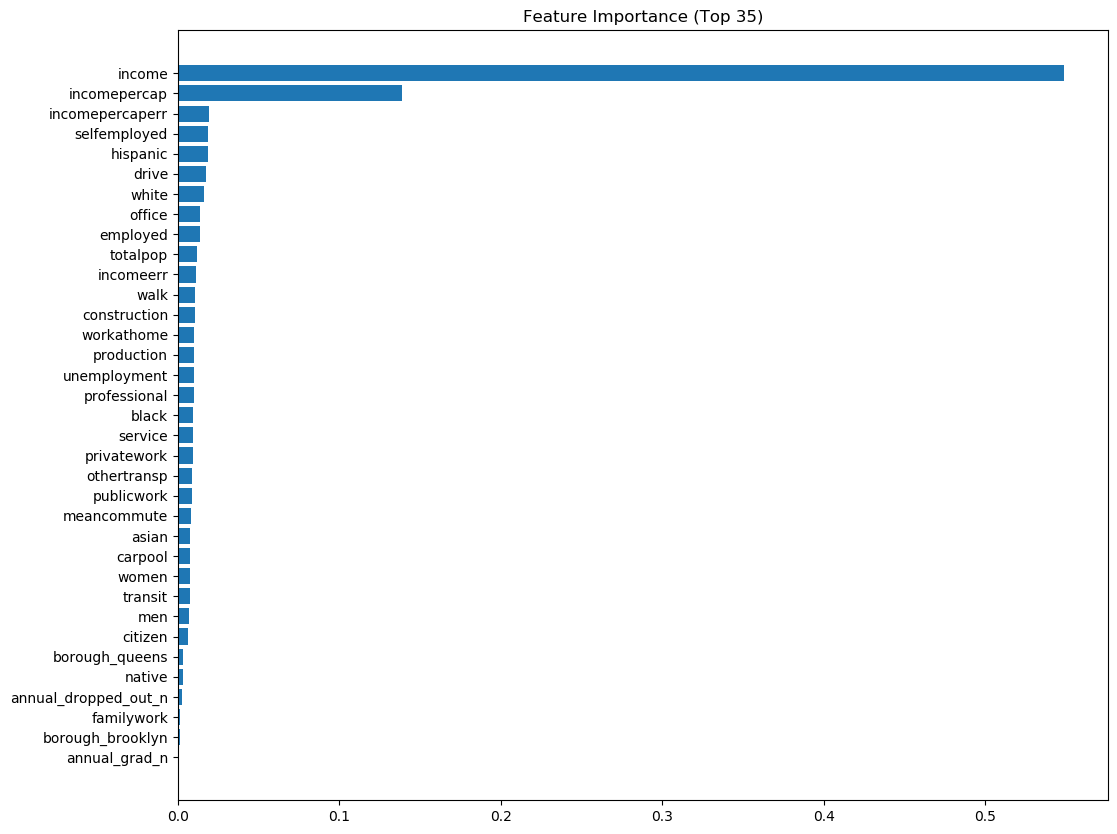

In [23]:
'''Citations:
https://www.rasgoml.com/feature-engineering-tutorials/how-to-generate-feature-importance-plots-from-scikit-learn;
OpenAI. (2021). ChatGPT [Computer software]. https://openai.com/'''
import matplotlib.pyplot as plt

feature_importance = xgb_tune_model.feature_importances_
feature_idx = np.argsort(feature_importance)
fig = plt.figure(figsize=(12, 10))
plt.barh(range(-1, -36, -1),
         feature_importance[feature_idx][-35:][::-1],
         align='center')
plt.yticks(range(-1, -36, -1), np.array(train_x01.columns)[feature_idx][-35:][::-1])
plt.title('Feature Importance (Top 35)')
plt.show()

#### Weighted Ensemble of XGBoost - Reccomended by AutoML App

In [24]:
# Train multiple Gradient Boosting Regressor models with different hyperparameters
models = []
models.append(('model1', GradientBoostingRegressor(max_depth=2, learning_rate=0.2, loss='ls')))
models.append(('model2', GradientBoostingRegressor(max_depth=3, learning_rate=0.1, loss='ls')))
models.append(('model3', GradientBoostingRegressor(max_depth=4, learning_rate=0.05, loss='ls')))
models.append(('model4', GradientBoostingRegressor(max_depth=5, learning_rate=0.01, loss='ls')))
models.append(('model5', GradientBoostingRegressor(max_depth=6, learning_rate=0.01, loss='ls')))

# Train the models and make predictions on the train data
predictions = []
weights = [0.2, 0.2, 0.2, 0.2, 0.2]
for name, model in models:
    model.fit(train_x01, train_y01)
    wr_y_pred = model.predict(train_x01)
    predictions.append(wr_y_pred)

# Combine the predictions with the weights to get the final prediction
wr_final_train_pred = np.average(predictions, axis=0, weights=weights)

In [25]:
# Train the models and make predictions on the test data
predictions = []
weights = [0.2, 0.2, 0.2, 0.2, 0.2]
for name, model in models:
    model.fit(train_x01, train_y01)
    wr_y_pred = model.predict(test_x01)
    predictions.append(wr_y_pred)

# Combine the predictions with the weights to get the final prediction
wr_final_test_pred = np.average(predictions, axis=0, weights=weights)

In [26]:
# Evaluate the performance of the model using root mean squared error
wr_train_mse = mean_squared_error(train_y01, wr_final_train_pred)
wr_train_rmse = wr_train_mse ** 0.5
wr_train_r2 = r2_score(train_y01, wr_final_train_pred)
print(f"Weighted Ensemble model train performance: RMSE = {wr_train_rmse:.3f}, R-squared = {wr_train_r2:.3f}")

# Evaluate the performance of the model using root mean squared error
wr_test_mse = mean_squared_error(test_y01, wr_final_test_pred)
wr_test_rmse = wr_test_mse ** 0.5
wr_test_r2 = r2_score(test_y01, wr_final_test_pred)
print(f"Weighted Ensemble model test performance: RMSE = {wr_test_rmse:.3f}, R-squared = {wr_test_r2:.3f}")

Weighted Ensemble model train performance: RMSE = 8.954, R-squared = 0.776
Weighted Ensemble model test performance: RMSE = 9.050, R-squared = 0.776


##### PyTorch Neural Network

In [38]:
import torch
import torch.nn as nn
import torch.optim as optim

# Convert Pandas dataframes to numpy arrays
np_train_x01 = train_x01.to_numpy()
np_train_y01 = train_y01
np_test_x01 = test_x01.to_numpy()
np_test_y01 = test_y01

# Define PyTorch neural network model
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.fc1 = nn.Linear(np_train_x01.shape[1], 10)
        self.fc2 = nn.Linear(10, 7)
        self.fc3 = nn.Linear(7, 5)
        self.fc4 = nn.Linear(5, 1)

    def forward(self, x):
        x = nn.functional.relu(self.fc1(x))
        x = nn.functional.relu(self.fc2(x))
        x = nn.functional.relu(self.fc3(x))
        x = self.fc4(x)
        return x

# Instantiate model, loss function, and optimizer
model = Net()
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.01)

# Train model for data
for epoch in range(300):
    inputs = torch.Tensor(np_train_x01)
    targets = torch.Tensor(np_train_y01).view(-1, 1)
    optimizer.zero_grad()
    outputs = model(inputs)
    loss = criterion(outputs, targets)
    loss.backward()
    optimizer.step()

In [39]:
# Evaluate model performance
inputs = torch.Tensor(np_test_x01)
targets = torch.Tensor(np_test_y01).view(-1, 1)
outputs = model(inputs)
Py_y_pred = outputs.detach().numpy().reshape(-1,)
Py_rmse = np.sqrt(mean_squared_error(np_test_y01, Py_y_pred))
Py_r2 = r2_score(np_test_y01, Py_y_pred)

print(f"PyTorch neural network model performance: RMSE = {Py_rmse:.3f}, R-squared = {Py_r2:.3f}")

PyTorch neural network model performance: RMSE = 10.353, R-squared = 0.707


## Release Resources

In [ ]:
%%html

<p><b>Shutting down your kernel for this notebook to release resources.</b></p>
<button class="sm-command-button" data-commandlinker-command="kernelmenu:shutdown" style="display:none;">Shutdown Kernel</button>
        
<script>
try {
    els = document.getElementsByClassName("sm-command-button");
    els[0].click();
}
catch(err) {
    // NoOp
}    
</script>

In [ ]:
%%javascript

try {
    Jupyter.notebook.save_checkpoint();
    Jupyter.notebook.session.delete();
}
catch(err) {
    // NoOp
}